# DBSCAN Clustering of Quake Tweets

We implement the DBSCAN algorithm in this notebook.

### Imports 

In [1]:
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from prettytable import PrettyTable
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
from cycler import cycler

# Use interactive matplotlib
%matplotlib widget

# Set up matplotlib rcParams (runtime configuration) for plot color
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


### Read in the data

In [2]:
# Read tweets
data_dir = os.path.realpath("../../data")
tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

### Data Preprocessing

In [3]:
# Remove tweets with no coordinates
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
        (tweets.latitude > 42.33278)
    &   (tweets.latitude < 51.08917)
    &   (tweets.longitude > -4.795556)
    &   (tweets.longitude < +8.230556)
]

# Order tweets by datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames'], inplace=True)
except:
    pass

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Convert tweets to geodataframe
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Project tweets to Lambert 93
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Reorder columns
tweets = tweets[['text', 'entity', 'wikidata', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [4]:
tweets.head()

,text,entity,wikidata,x_m,y_m,createdAt,geometry
id,,,,,,,
1,il y a 23 min #seisme 2.0 a frappé Arbaz (Sion...,Arbaz,Q68113,1037421.834,6583455.288,2019-11-11 09:23:24+00:00,POINT (1037421.834 6583455.288)
2,Tremblement de terre à Lyon en ce moment !!!,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:46+00:00,POINT (843121.942 6519367.222)
3,#Séisme ressenti à #Lyon à l'instant,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:56+00:00,POINT (843121.942 6519367.222)
4,Tremblement de terre en Ardèche à l'instant,Ardèche (département),Q3148,812290.663,6397402.763,2019-11-11 10:54:09+00:00,POINT (812290.663 6397402.763)
5,Wait ! Y’a des tremblements de terre en France...,France,Q142,624015.535,6656012.010,2019-11-11 10:54:18+00:00,POINT (624015.535 6656012.010)


### Clustering using DBSCAN

In [5]:
# Scale coordinates to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tweets[['x_m', 'y_m']])

# Include time
add_time = True

if add_time:
    # Convert datetime (in ns) to seconds, // (floor division) 10 ** 9 to get seconds
    tweets['ts'] = (tweets['createdAt'].values.astype(np.int64) // 10 ** 9)
    # Convert ts in tweets to cumulative seconds
    tweets['ts'] -= tweets['ts'].min()

    # ts, x_m_norm, y_m_norm
    scaled = np.hstack((tweets['ts'].values.reshape(-1, 1), scaled))


# Test if ts column exists in tweets
if 'ts' in tweets.columns:
    suffix = '_ts'
else:
    suffix = ''

In [6]:
# Will be used for plotting 
COORDS = tweets.loc[:, ['x_m','y_m']].values

# DBSCAN Clustering
# Parameters
n_clusters = 3

# Run ST-DBSCAN
start = time.time()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaled)
end = time.time()

result = [
    ['Time (s)', '# of clusters'],
    [round(end - start, 2), len(set(kmeans.labels_))]
]

table = PrettyTable(result[0])
table.add_row(result[1])
print(table)

# Add cluster column to tweets
tweets['cluster'] = kmeans.labels_

# Create a multiindex
# Test whether cluster is an index
if "cluster" not in tweets.index.names:
    tweets.sort_values(by="cluster", inplace=True)
    tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
    tweets.drop(columns=['cluster'], inplace=True)
    

+----------+---------------+
| Time (s) | # of clusters |
+----------+---------------+
|   0.84   |       3       |
+----------+---------------+


### Create convex hulls for each cluster

In [7]:
# Create a hulls geodataframe
hulls = gpd.GeoDataFrame(columns=['num_tweets', 'area_km2', 'geometry'])

for cluster in set(kmeans.labels_):
    if cluster != -1:
        # Get the coordinates of the points in the cluster
        points = COORDS[kmeans.labels_ == cluster]
        # Create a convex hull
        try:
            hull = ConvexHull(points)
        except:
            continue
        # Append the cluster and hull to the geodataframe using concat instead of append
        hulls = pd.concat([hulls, gpd.GeoDataFrame({
            'cluster': [cluster],
            'num_tweets': [len(points)],
            'geometry': [Polygon(points[hull.vertices])]
        })], ignore_index=True)

hulls['cluster'] = hulls['cluster'].astype(int)

hulls.set_crs(epsg=2154, inplace=True)

# Calculate the area of the hulls
hulls['area_km2'] = round(hulls['geometry'].area / 1_000_000, 2)

# Clusters with no hulls
u_set = set(tweets.index.get_level_values(0)) - set(hulls['cluster']) - {-1}
print(f"Clusters with hulls: {set(hulls['cluster'])}")
print("Clusters with no hulls: ", u_set)

# Remove tweet clusters with no hulls
tweets = tweets[~tweets.index.get_level_values(0).isin(u_set)]

# Restart cluster ids for clusters different than -1
tweets.reset_index('cluster', inplace=True)
tweets.loc[tweets['cluster'] != -1, 'cluster'] = tweets.loc[tweets['cluster'] != -1, 'cluster'].astype('category').cat.codes

# Recreate multiindex
tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
tweets.drop(columns=['cluster'], inplace=True)

# Restart hulls cluster ids
hulls['cluster'] = hulls['cluster'].astype('category').cat.codes

Clusters with hulls: {0, 1, 2}
Clusters with no hulls:  set()


C:\Users\Salah\AppData\Local\Temp\ipykernel_20152\79091779.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tweets.loc[tweets['cluster'] != -1, 'cluster'] = tweets.loc[tweets['cluster'] != -1, 'cluster'].astype('category').cat.codes


In [8]:
hulls.head()

,num_tweets,area_km2,geometry,cluster
0,1420,547722.16,"POLYGON ((252952.949 6783616.406, 397280.540 6...",0
1,846,542152.75,"POLYGON ((1043969.540 6298511.488, 1051470.999...",1
2,2927,513750.00,"POLYGON ((619017.170 7095479.908, 252952.949 6...",2


### Plot the clusters

In [9]:
# Read France geojson
france = gpd.read_file(filename='../../data/france.geojson')
france = france.to_crs("EPSG:2154")

Cluster 0: 1420 tweets
Cluster 1: 846 tweets
Cluster 2: 2927 tweets


Text(0.02, 0.98, '$n_{clusters}=3$ clusters')

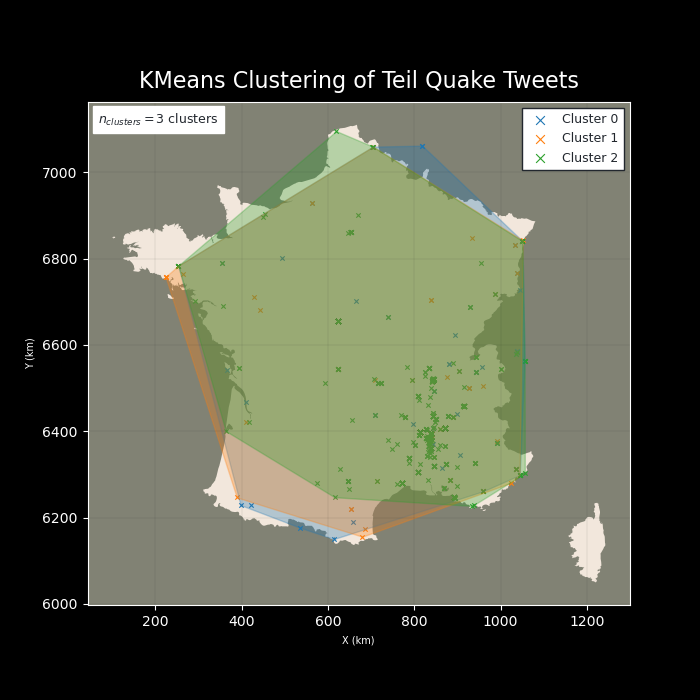

In [10]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')
base.get_figure().patch.set_facecolor('#22272e')

# Plot tweets with color based on cluster
for cluster in tweets.index.get_level_values(0).unique():
    # Number of tweets in cluster
    num_tweets = len(tweets[tweets.index.get_level_values(0) == cluster])
    # Check whether cluster id exists in hulls
    if cluster in hulls.cluster.values or cluster == -1:
        print("Cluster {}: {} tweets".format(cluster, num_tweets))
        tweets[tweets.index.get_level_values(0) == cluster].plot(
            ax=base,
            markersize=6 if cluster == -1 else 10,
            label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster),
            marker='x' if cluster != -1 else '+',
            color='#161819' if cluster == -1 else 'C{}'.format(cluster),
            linewidth=0.5 if cluster == -1 else 0.8,
        )
    
for cluster in hulls.cluster:
    hulls[hulls.cluster == cluster].plot(
        ax=base,
        alpha=0.3,
        color='C{}'.format(cluster),
        edgecolor='C{}'.format(cluster),
        linewidth=1
    )

# Set title
base.set_title("KMeans Clustering of Teil Quake Tweets", fontsize=16, weight='medium', color='white', pad=10)

# Set legend
base.legend(loc='best', fontsize=9, labelcolor='#22272e', markerscale=2, facecolor='white', title_fontsize=14, fancybox=False, framealpha=1, edgecolor='#22272e')
# bbox_to_anchor=(1.23, 1.01

# Add grid
base.grid(color='#161819', linestyle='-', linewidth=0.2, alpha=0.3)

# Change tick labels
m2km = lambda x, _: f'{x/1000:g}'
base.xaxis.set_major_formatter(m2km)
base.yaxis.set_major_formatter(m2km)

# Set axis labels
base.set_xlabel("X (km)", fontsize=7, labelpad=5, color='white')
base.set_ylabel("Y (km)", fontsize=7, labelpad=5, color='white')

# Set axis ticks color
base.tick_params(axis='x', colors='white')
base.tick_params(axis='y', colors='white')

textstr = (
    r'$n_{clusters}=%.0f$ clusters' % (n_clusters, ))

# these are matplotlib.patch.Patch properties
props = dict(facecolor='white')

# place a text box in upper left in axes coords
base.text(0.02, 0.98, textstr, transform=base.transAxes, fontsize=9,
        verticalalignment='top', bbox=props, color='#22272e')

In [11]:
# Save figure
base.get_figure().savefig(f'../images/kmeans/kmeans_{n_clusters}_clusters{suffix}.png', dpi=300, bbox_inches='tight', facecolor=base.get_figure().get_facecolor(), edgecolor='none')